* This notebook was made to further look at trajectory comparisons under different conditions. New/old river treatment; With/Without wind; Default/reduced vertical viscosity; With banks/without banks.

In [1]:
%matplotlib inline
from matplotlib import pylab,dates
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import datetime as dt
import matplotlib.cm as cm
import pytz, datetime
import glob
import os
import urllib2
import csv
import cStringIO
import requests
from xml.etree import cElementTree as ElementTree
import pandas as pd
import arrow
from IPython.core.display import Image

from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools

from __future__ import division

In [2]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy, X, Y = tidetools.get_bathy_data(grid)
lats = grid.variables['nav_lat']
lons = grid.variables['nav_lon']
bath = grid.variables['Bathymetry']

In [4]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
nc_tools.show_variables(tracersT)
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']
nc_tools.timestamp(tracersT, 0)

[u'deptht', u'nav_lat', u'nav_lon', u'rain_rate', u'snow_rate', u'sossheig', u'time_counter', u'time_counter_bnds', u'vosaline', u'votemper']


<Arrow [2014-10-08T00:30:00+00:00]>

In [5]:
def plotoct(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
    viz_tools.plot_coastline(ax1,grid,coords='map')
    viz_tools.plot_coastline(ax1,grid,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(ax1,grid,coords='map',isobath=20,color='OrangeRed')
    ax1.set_xlim([-123.6,-123])
    ax1.set_ylim([48.8,49.4])
    ax1.scatter(lon[1:,part],lat[1:,part],color='DodgerBlue',marker='o',label='Model')
    ax1.scatter(lon[0,part],lat[0,part],color='0.30',marker='s')
    ax1.plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    ax1.legend(loc='upper left')
    
    ax2.plot(timesteps[0:48],ssh[0:48,466,329],'-k')
    
    ax2.set_xticklabels([])
    ax2.set_ylabel('Water level (m)')
    ax2.set_xlabel('Oct 8 - Oct 9 (hrs)')
    ax2.set_title('sossheig, ~Point Atkinson')
        
    t=hour
    ax2.plot([timesteps[t],timesteps[t]],[-2.0,1.5],'r-',label='start')
    
    t2=hour+duration
    ax2.plot([timesteps[t2],timesteps[t2]],[-2.0,1.5],'b-',label='end')
    
    [wind_speed,wind_dir,temp,time, lat, lon] = stormtools.get_EC_observations('Sandheads',start,end)
    
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(11, 5))
    ax3.plot(time,wind_speed,'-k')
    ax3.set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    ax3.set_xticklabels([])
    ax3.set_xlabel('Oct 8 - Oct 9 (hrs)')
    ax3.set_ylabel('Wind Speed (m/s)')
    ax3.set_title('Sandheads')
    
    diff = 24 - hour
    hour2 = duration - diff
    if hour2 > 0:
        day = day
        day2 = day + 1
        hour2 = hour2
    else:
        day = day
        day2 = day
        hour2 = hour+duration
    
    t=dt.datetime(2014,10,day,hour,minute)
    ax3.plot([t,t],[0,10],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    ax3.plot([tt,tt],[0,10],'b-',label='end')
    ax3.legend(loc='upper left')

    ax4.plot(time,wind_dir,'-k')
    ax4.set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    ax4.set_xticklabels([])
    ax4.set_xlabel('Oct 8 - Oct 9 (hrs)')
    ax4.set_ylabel('Wind Direction (deg CCW of E)')
    ax4.set_title('Sandheads')
    

    t=dt.datetime(2014,10,day,hour,minute)
    ax4.plot([t,t],[0,350],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    ax4.plot([tt,tt],[0,350],'b-',label='end')
    ax4.legend(loc='upper left')

In [6]:
def plotoct_mewold(lon,lat,part,start,end,start_d,end_d,day,hour,minute,duration):
    fig, axs = plt.subplots(2, 2, figsize=(11, 10))
    viz_tools.plot_coastline(axs[0,0],grid,coords='map')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=4,color='FireBrick')
    viz_tools.plot_coastline(axs[0,0],grid,coords='map',isobath=20,color='OrangeRed')
    axs[0,0].set_xlim([-123.6,-123])
    axs[0,0].set_ylim([48.8,49.4])
    colors=['g','DodgerBlue']
    for i, key in enumerate(lon.keys()):
        axs[0,0].scatter(lon[key][1:,part],lat[key][1:,part],marker='o',color=colors[i],label=key)
        axs[0,0].scatter(lon[key][0,part],lat[key][0,part],color='0.30',marker='s')
    axs[0,0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    axs[0,0].legend(loc='upper left')
    
    axs[0,1].plot(timesteps[0:48],ssh[0:48,466,329],'-k')
    
    axs[0,1].set_xticklabels([])
    axs[0,1].set_ylabel('Water level (m)')
    axs[0,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[0,1].set_title('sossheig, ~Point Atkinson')
        
    t=hour
    axs[0,1].plot([timesteps[t],timesteps[t]],[-2.0,1.5],'r-',label='start')
    
    t2=hour+duration
    axs[0,1].plot([timesteps[t2],timesteps[t2]],[-2.0,1.5],'b-',label='end')
    
    [wind_speed,wind_dir,temp,time, lat, lon] = stormtools.get_EC_observations('Sandheads',start,end)
    
    #fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(11, 5))
    axs[1,0].plot(time,wind_speed,'-k')
    axs[1,0].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,0].set_xticklabels([])
    axs[1,0].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,0].set_ylabel('Wind Speed (m/s)')
    axs[1,0].set_title('Sandheads')
    
    diff = 24 - hour
    hour2 = duration - diff
    day2 = day +1
    
    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,0].plot([t,t],[0,10],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,0].plot([tt,tt],[0,10],'b-',label='end')
    axs[1,0].legend(loc='upper left')

    axs[1,1].plot(time,wind_dir,'-k')
    axs[1,1].set_xlim(dt.datetime(2014,10,start_d),dt.datetime(2014,10,end_d))
    axs[1,1].set_xticklabels([])
    axs[1,1].set_xlabel('Oct 8 - Oct 9 (hrs)')
    axs[1,1].set_ylabel('Wind Direction (deg CCW of E)')
    axs[1,1].set_title('Sandheads')
    

    t=dt.datetime(2014,10,day,hour,minute)
    axs[1,1].plot([t,t],[0,350],'r-',label='start')
    tt=dt.datetime(2014,10,day2,hour2,minute)
    axs[1,1].plot([tt,tt],[0,350],'b-',label='end')
    axs[1,1].legend(loc='upper left')
    return fig

* Oct8 drop1

In [7]:
lon112={};lat112={}
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['new']=o112.variables['traj_lon']
lat112['new']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop1/\
12/ariane_trajectories_qualitative.nc','r')
lon112['old']=o112.variables['traj_lon']
lat112['old']=o112.variables['traj_lat']

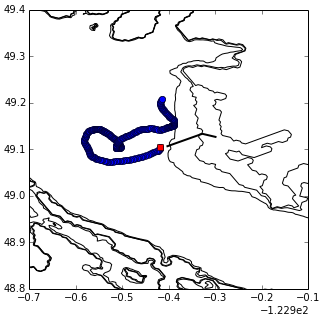

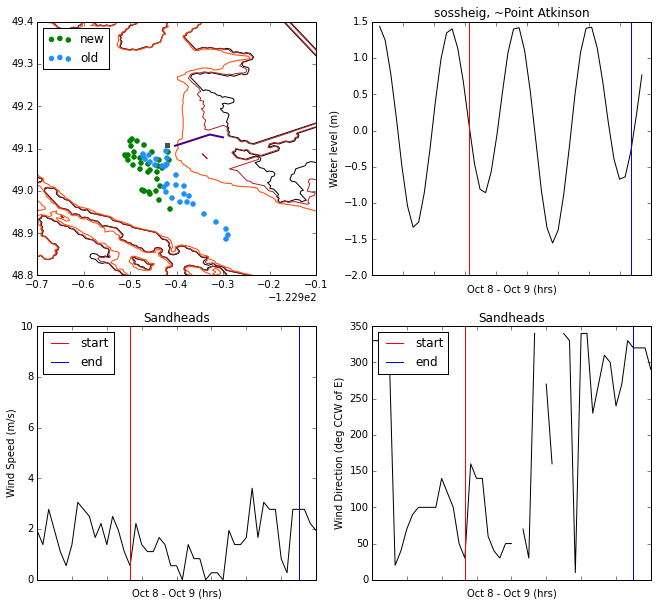

In [8]:
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop112a.png')

* Drop2

In [9]:
lon212={}; lat212={}
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['new']=o212.variables['traj_lon']
lat212['new']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/drifters/oct8/drop2/\
12/ariane_trajectories_qualitative.nc','r')
lon212['old']=o212.variables['traj_lon']
lat212['old']=o212.variables['traj_lat']

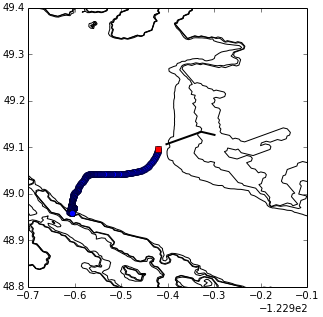

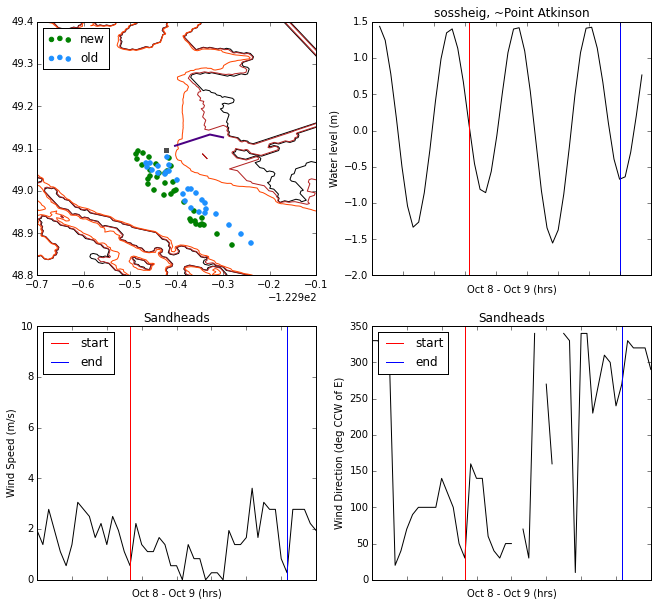

In [10]:
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop212a.png')

# Comparison with no wind case from Oct8-10

In [11]:
lon112={};lat112={}
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['wind']=o112.variables['traj_lon']
lat112['wind']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10nowind/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['no_wind']=o112.variables['traj_lon']
lat112['no_wind']=o112.variables['traj_lat']

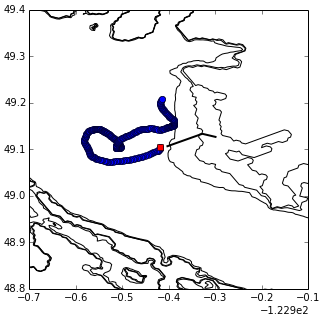

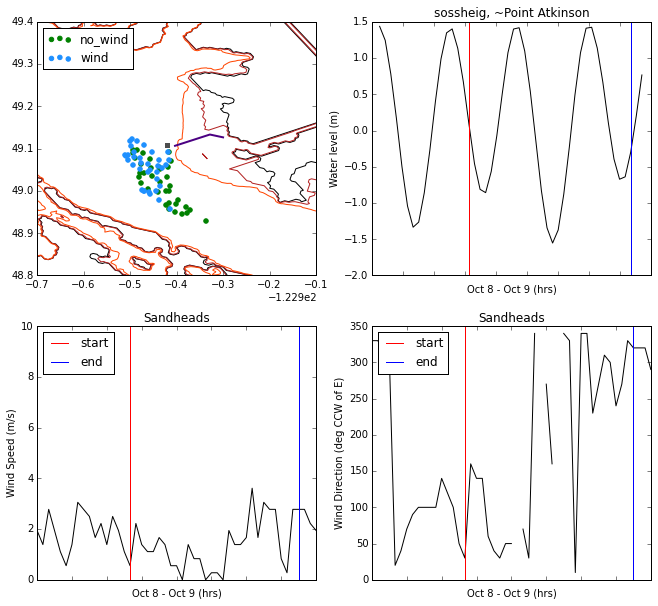

In [12]:
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop112a.png')

In [13]:
lon212={}; lat212={}
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['wind']=o212.variables['traj_lon']
lat212['wind']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10nowind/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['no_wind']=o212.variables['traj_lon']
lat212['no_wind']=o212.variables['traj_lat']

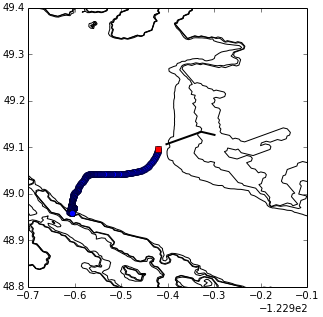

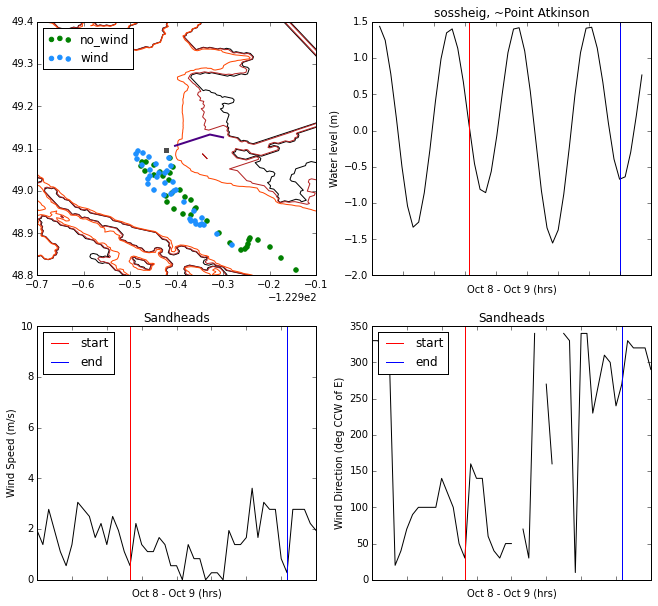

In [14]:
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop212a.png')

# Comparison with reduced vertical eddy viscosity case from Oct8-10

In [15]:
lon112={};lat112={}
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['default']=o112.variables['traj_lon']
lat112['default']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['reduced_viscosity']=o112.variables['traj_lon']
lat112['reduced_viscosity']=o112.variables['traj_lat']

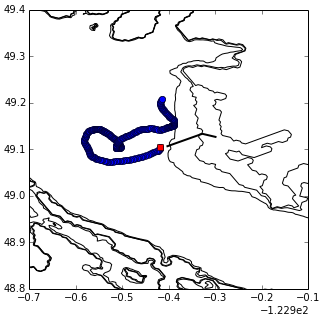

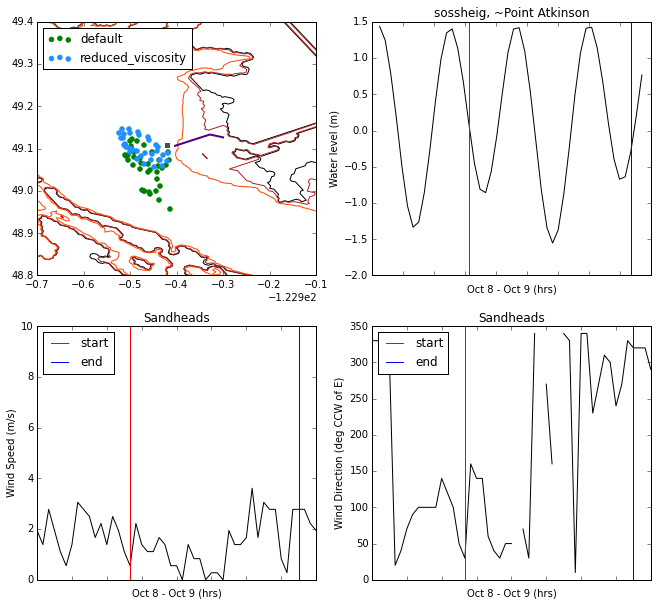

In [16]:
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop112a.png')

In [17]:
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop1/\
ariane_trajectories_qualitative.nc')
lon112=o112.variables['traj_lon']
lat112=o112.variables['traj_lat']

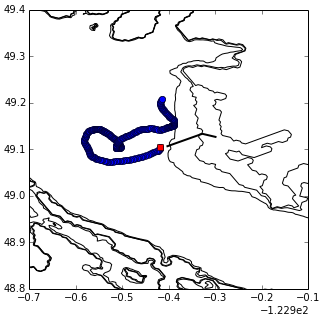

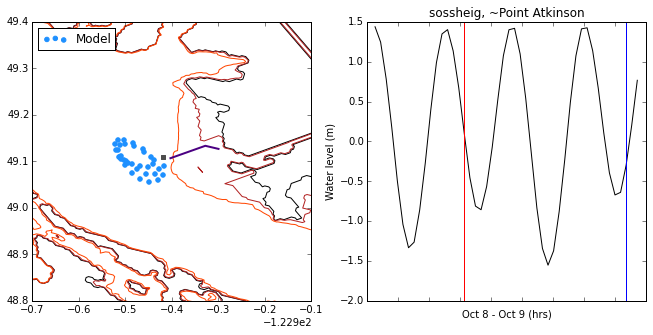

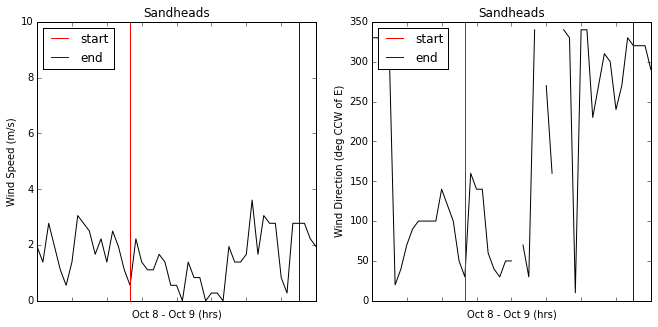

In [18]:
plotoct(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop112a.png')

In [19]:
lon212={}; lat212={}
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['default']=o212.variables['traj_lon']
lat212['default']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['reduced_viscosity']=o212.variables['traj_lon']
lat212['reduced_viscosity']=o212.variables['traj_lat']

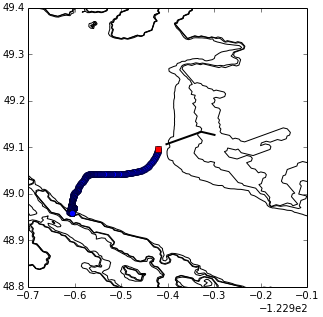

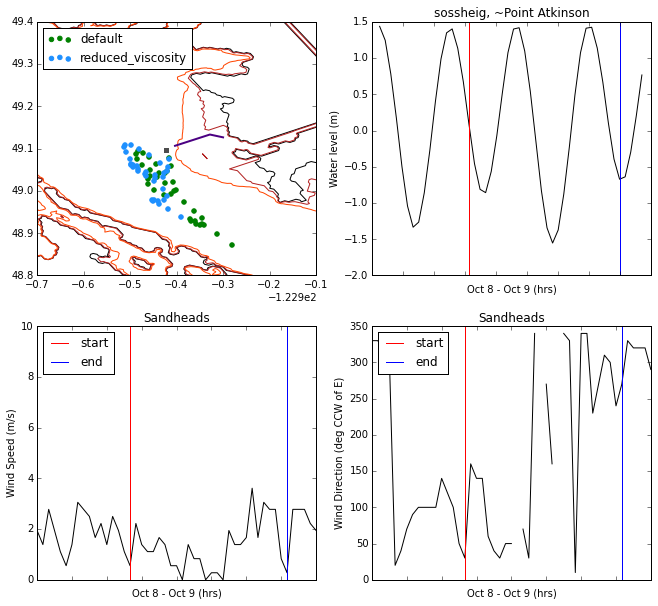

In [20]:
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop212a.png')

In [21]:
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10reduceviscosity/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212=o212.variables['traj_lon']
lat212=o212.variables['traj_lat']

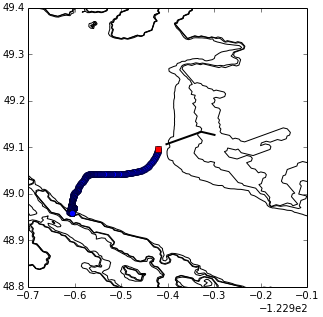

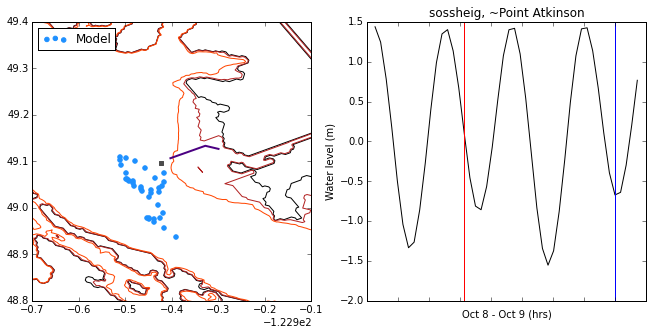

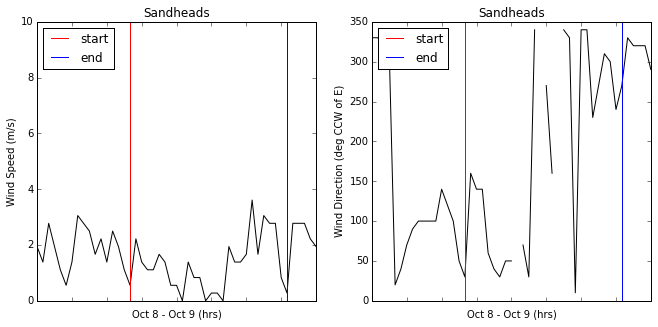

In [22]:
plotoct(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop212a.png')

* reduced viscosity case seems promissing. Less mixing between two vertical layers...

# Comparison with no banks in the model from Sep25-Oct7 spin up and Oct8-10 simulation

In [23]:
lon112={};lat112={}
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['default']=o112.variables['traj_lon']
lat112['default']=o112.variables['traj_lat']
o112 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10nobanks/drop1/\
ariane_trajectories_qualitative.nc','r')
lon112['no_banks']=o112.variables['traj_lon']
lat112['no_banks']=o112.variables['traj_lat']

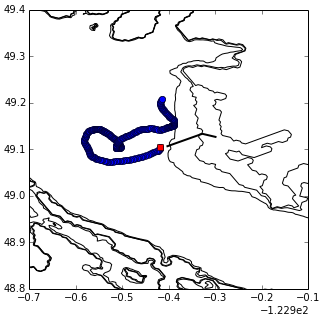

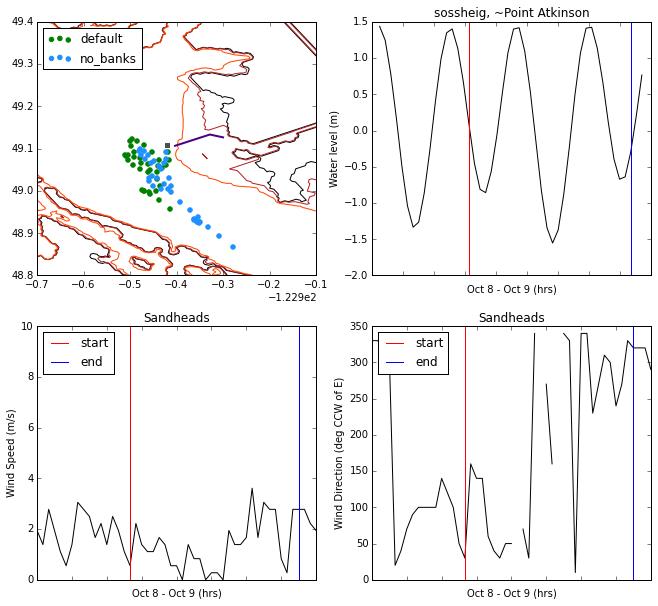

In [24]:
fig=plotoct_mewold(lon112,lat112,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,29)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop112a.png')

In [25]:
lon212={}; lat212={}
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10RFdailySmoo/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['default']=o212.variables['traj_lon']
lat212['default']=o212.variables['traj_lat']
o212 = nc.Dataset('/ocean/jieliu/research/meopar/Ariane/result/oct8_10nobanks/drop2/\
ariane_trajectories_qualitative.nc','r')
lon212['no_banks']=o212.variables['traj_lon']
lat212['no_banks']=o212.variables['traj_lat']

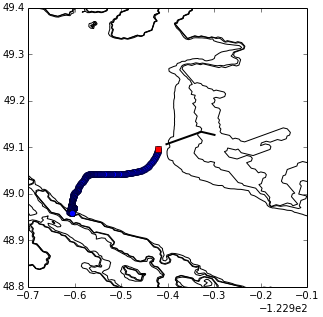

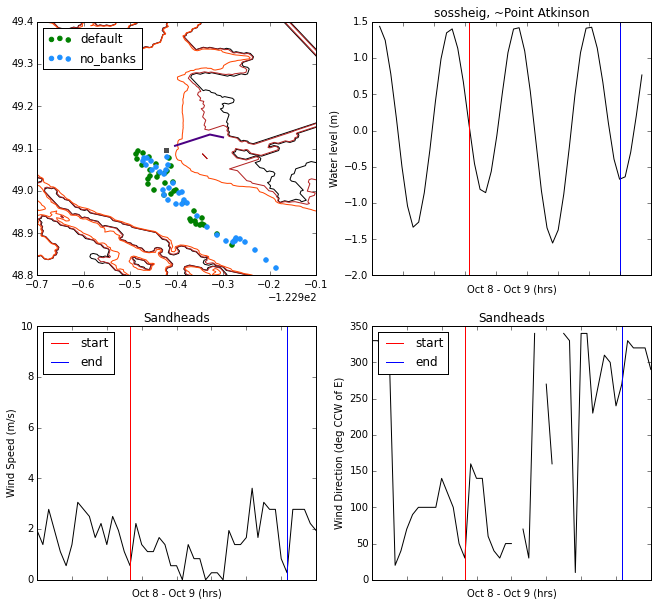

In [26]:
fig = plotoct_mewold(lon212,lat212,0,'7-Oct-2014','11-Oct-2014',8,10,8,16,0,27)
Image(filename='/ocean/imachuca/MEOPAR/analysis/Idalia/drop212a.png')

* For no banks and no winds, particle moves further southward which is interesting.